In [1]:
import matplotlib.image as mpimg
import numpy as np
import pickle
import glob
import time
import os
import collections
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from lesson_functions2 import draw_boxes
from lesson_functions2 import extract_features
from lesson_functions2 import search_windows
from lesson_functions2 import slide_window
from lesson_functions2 import show_image

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

obj_file = 'training_data.p'
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

Feature Extraction and Loading


In [2]:
if os.path.isfile(obj_file):

    print('Extraction data exists')
    with open(obj_file, "rb") as f:
        params = pickle.load(f)
        cell_per_block = params['cell_per_block']
        color_space = params['color_space']
        hist_bins = params['hist_bins']
        hog_channel = params['hog_channel']
        pix_per_cell = params['pix_per_cell']
        orient = params['orient']
        spatial_size = params['spatial_size']
        y_start_stop = params['y_start_stop']

        car_features = params['car_features']
        notcar_features = params['notcar_features']

        print('Features are loaded', color_space)

else:
    print('Extraction data does NOT exist, extraction features')

    cars = glob.glob("training_data/vehicles/**/*.png", recursive=True)
    notcars = glob.glob("training_data/non-vehicles/**/*.png", recursive=True)

    # sample_size = 500
    # cars = car_paths[0:sample_size]
    # notcars = notcar_paths[0:sample_size]

    color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8  # HOG pixels per cell
    cell_per_block = 2  # HOG cells per block
    hog_channel = 0  # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16)  # Spatial binning dimensions
    hist_bins = 32  # Number of histogram bins
    y_start_stop = [370, 580]  # Min and max in y to search in slide_window()

    car_features = extract_features(cars, color_space=color_space,
                                    spatial_size=spatial_size, hist_bins=hist_bins,
                                    orient=orient, pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    hog_channel=hog_channel, spatial_feat=spatial_feat,
                                    hist_feat=hist_feat, hog_feat=hog_feat)

    notcar_features = extract_features(notcars, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
    # Persist some data for later use
    with open(obj_file, 'wb') as obj_file:
        training_data = {
            'cell_per_block': cell_per_block,
            'color_space': color_space,
            'hist_bins': hist_bins,
            'hog_channel': hog_channel,
            'pix_per_cell': pix_per_cell,
            'orient': orient,
            'spatial_size': spatial_size,
            'y_start_stop': y_start_stop,

            'car_features': car_features,
            'notcar_features': notcar_features
        }
        pickle.dump(training_data, obj_file)


Extraction data exists
Features are loaded YCrCb


In [3]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2628
9.57 Seconds to train SVC...
Test Accuracy of SVC =  0.9713


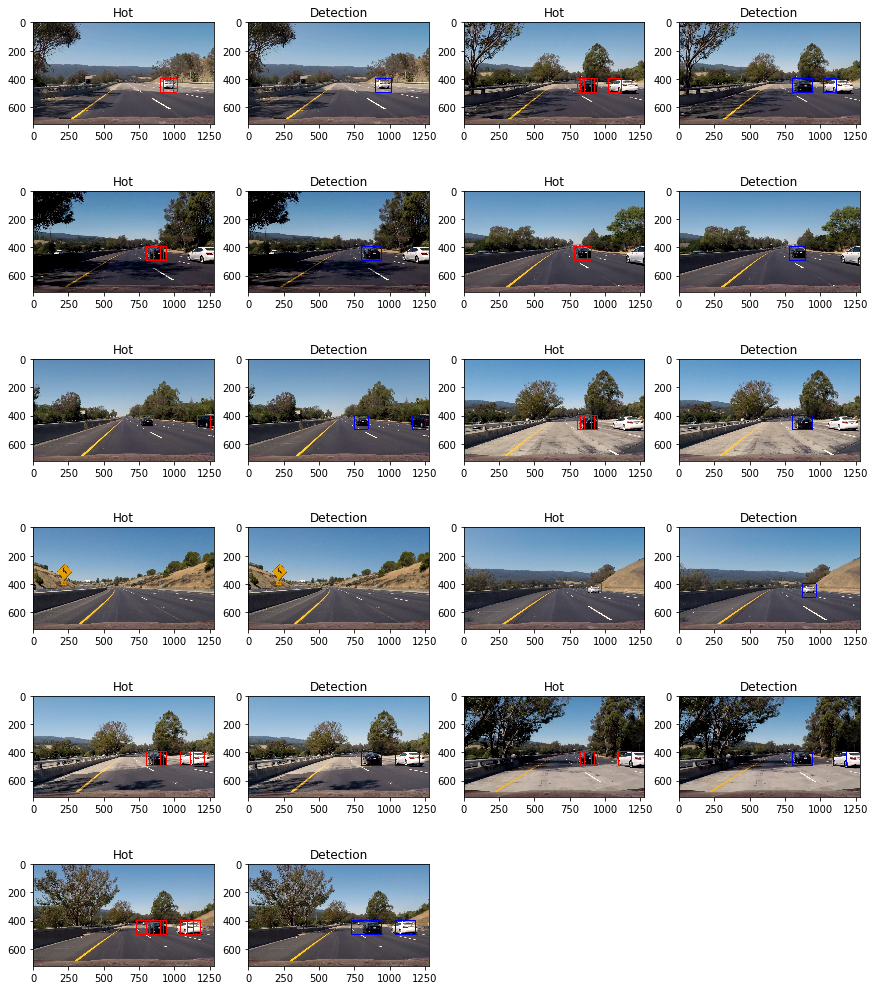

In [4]:
# Search Windows
que_len = 7
prev_heat = collections.deque(maxlen=que_len)
threshold = 3
def process_image(img_rgb, video=True, debug=False):
    draw_image = np.copy(img_rgb)

    # Re-scale JPG (0 to 255) image to PNG (0 to 1)
    img = img_rgb.astype(np.float32)/255

    windows = slide_window(img, y_start_stop=[400, 500], x_start_stop=[370, None], xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows += slide_window(img, y_start_stop=[400, 500], x_start_stop=[320, None], xy_window=(144, 144), xy_overlap=(0.75, 0.75))
    windows += slide_window(img, y_start_stop=[430, 550], x_start_stop=[250, None], xy_window=(192, 192), xy_overlap=(0.75, 0.75))
    windows += slide_window(img, y_start_stop=[460, 580], x_start_stop=[250, None], xy_window=(192, 192), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat, hog_feat=hog_feat)
    #window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

    global prev_heat
    heat = np.zeros((720, 1280))
    for box in hot_windows:
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        if video: 
            prev_heat.append(heat)
            heat = np.sum(np.array(prev_heat), axis=0)
            if len(prev_heat) == que_len:
                heat[heat <= threshold] = 0
    
    # label heat
    pix, n_car = label(heat)
    new_boxes = []
    for i in range(1, n_car + 1):
        nonzero = (pix == i).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        box = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        new_boxes.append(box)

    img_box = draw_boxes(draw_image, new_boxes, color=(0, 0, 255))
    img_grid = draw_boxes(draw_image, hot_windows, color=(255, 0, 0))

    img_hot = np.hstack((heat, heat, heat))

    if debug:
        #print("New boxes: ", new_boxes, 'pix:', pix.shape, 'n_car:', n_car,'Shape:', img_hot.shape)
        return img_box, img_grid
    else:
        return img_box


path_list = glob.glob('test_images/*.jpg')
img_list = []
lbl_list = []

for path in path_list:
    image = mpimg.imread(path)
    image_box, image_grid = process_image(image, debug=True, video=False)
    img_list.append(image_grid)
    lbl_list.append('Hot')
    img_list.append(image_box)
    lbl_list.append('Detection')

show_image(img_list, lbl_list, cols=4, fig_w=12, fig_h=14)

In [6]:
def generate_video(video_in_name, video_out_name, start=0, stop=0):

    if stop > start:
        video_input = VideoFileClip(video_in_name).subclip(start, stop)
    else:
        video_input = VideoFileClip(video_in_name)

    video_proc = video_input.fl_image(process_image)    
    %time video_proc.write_videofile(video_out_name, audio=False)
    

vid_input, vid_output ='project_video.mp4', 'project_video_output.mp4'
generate_video(vid_input, vid_output)
# generate_video(vid_input, vid_output, start=10, stop=20)

HTML("""
<video width='960' height='540' controls>
    <source src='{}'>
</video>
""".format(vid_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:02<00:00,  2.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 17s, sys: 1min 9s, total: 5min 26s
Wall time: 6min 4s
